In [1]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [84]:
class dCrawler:
    def __init__(self,threshold=1.5): #just a placeholder value user need to the define at the call
        self.threshold = threshold
        self.centroids = None
        self.clusters = None 
        self.points = None #initialise the points to none ref at the start, fix the bug of points not being defined 
        self.history = [] #for anim saving states for each step
 
    def fit(self, points):
        self.points = points
        self.centroids, self.clusters = self._crawler(points)
        #removed because I update at each step: self.history.append((deepcopy(self.centroids), deepcopy(self.clusters), "Initial Crawl"))  #deepcopy to avoid the reference issue and overwriting each state is copied independently without overwriting the previous one
        self.centroids, self.clusters = self._adjust_clusters(points)
        #removed because I update at each step: self.history.append((deepcopy(self.centroids), deepcopy(self.clusters), "Adjust Steps"))
        self.centroids, self.clusters = self._merge_clusters(points)
        #removed because I update at each step: self.history.append((deepcopy(self.centroids), deepcopy(self.clusters), "Merge Steps"))
        self._cleanup_clusters()
        self.history.append((deepcopy(self.centroids), deepcopy(self.clusters), "Cleanup clusters"))
        return self

    def predict(self, points):
        if self.centroids is None or self.clusters is None:
            raise ValueError("Model not fitted yet. Call 'fit' before 'predict'.")

        kdtree = cKDTree(self.centroids)
        _, labels = kdtree.query(points)
        return labels

    def _distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _crawler(self, points):
        n = len(points)
        centroids = []
        clusters = []
        assigned = np.zeros(n, dtype=bool)

        vis_centroids = centroids
        vis_clusters = clusters

        i = 0
        while i < n:
            if not assigned[i]:
                centroid = points[i]
                cluster = [i]
                assigned[i] = True
                
                while True:
                    distances = np.sqrt(np.sum((points[~assigned] - centroid) ** 2, axis=1))
                    if len(distances) == 0:
                        break

                    closest_idx = np.argmin(distances)
                    closest_point = points[~assigned][closest_idx]

                    if distances[closest_idx] <= self.threshold:
                        cluster.append(np.where(~assigned)[0][closest_idx])
                        assigned[np.where(~assigned)[0][closest_idx]] = True
                        centroid = np.mean(points[cluster], axis=0)

                        distances = np.sqrt(np.sum((points[cluster] - centroid) ** 2, axis=1))
                        cluster = [c for c, d in zip(cluster, distances) if d <= self.threshold]
                        assigned[cluster] = True

                        #Add step for animation
                        vis_centroids = centroids.copy()
                        vis_clusters = clusters.copy()

                        vis_centroids.append(centroid)
                        vis_clusters.append(cluster)
                        self.history.append((deepcopy(vis_centroids), deepcopy(vis_clusters), "Initial Crawl"))
                        
                    else:
                        break

                centroids.append(centroid)
                clusters.append(cluster)

                vis_centroids = centroids
                vis_clusters = clusters

            i += 1

        return centroids, clusters

    def _adjust_clusters(self, points):
        n = len(points)
        assigned = np.zeros(n, dtype=bool)

        while True:
            kdtree = cKDTree(self.centroids)
            _, labels = kdtree.query(points)

            if np.all(assigned == labels):
                break

            assigned = labels

            for i in range(len(self.centroids)):
                cluster_points = points[labels == i]
                if len(cluster_points) > 0:
                    self.centroids[i] = np.mean(cluster_points, axis=0)

        self.clusters = [np.where(labels == i)[0] for i in range(len(self.centroids))]
        
        #Add step for animation
        self.history.append((deepcopy(self.centroids), deepcopy(self.clusters), "Adjust Phase"))
        
        return self.centroids, self.clusters

    def _merge_clusters(self, points):
        cluster_thresh = self.threshold
        n_loop = 0

        while True:
            merged = False
            kdtree = cKDTree(self.centroids)
            distances, _ = kdtree.query(self.centroids, k=2)
            distances = distances[:, 1]

            merge_indices = np.where(distances <= cluster_thresh)[0]
            #Removed list - this needs to be added to account for the fact that if the cluster has already been merged then we skip it
            removed_list = []
            for i in merge_indices:
                #j = np.argmin(np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1))) --> Here's the problem this should find the second one instead, because the minimum will be itself
                ds = np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1)) # Get all the distances
                ds[i] = cluster_thresh #change it to the cluster thresh
                j = np.argmin(ds) #so now j should be different to i unless it is above the cluster_threshold

                if i != j:
                    if i not in removed_list:
                        self.centroids[i] = np.mean([self.centroids[i], self.centroids[j]], axis=0) #
                        #self.clusters[i].extend(self.clusters[j]) --> you can't extend a numpy array will concatenate instead
                        self.clusters[i] = np.concatenate((self.clusters[i], self.clusters[j]))
                        self.clusters[j] = []
                        merged = True
                        if len(self.clusters[i]) > 0: #check if the cluster is empty, fix the issue with the range of thresholds
                            cluster_indices = self.clusters[i].astype(int)
                            distances = np.sqrt(np.sum((points[cluster_indices] - self.centroids[i]) ** 2, axis=1))
                            self.clusters[i] = [c for c, d in zip(self.clusters[i], distances) if d <= self.threshold]
                        removed_list.append(j) #add j to the exclude list
            if not merged:
                break

            self.centroids = [c for c, cl in zip(self.centroids, self.clusters) if len(cl) > 0]
            self.clusters = [cl for cl in self.clusters if len(cl) > 0]

            unassigned_points = np.where(np.isin(np.arange(len(points)), np.concatenate(self.clusters), invert=True))[0]

            if len(unassigned_points) > 0:
                new_centroids, new_clusters = self._crawler(points[unassigned_points])
                self.centroids.extend(new_centroids)
                self.clusters.extend(new_clusters)
                n_loop += 1
            
            #Add in the adjust step
            self.centroids, self.clusters = self._adjust_clusters(points)
            
            if n_loop > 20:
                break

            cluster_thresh *= 0.95

        return self.centroids, self.clusters

    def _cleanup_clusters(self):
        cluster_ids = np.zeros(len(np.concatenate(self.clusters)), dtype=int)
        for i, cluster in enumerate(self.clusters):
            cluster_ids[cluster] = i + 1

        self.clusters = [np.where(cluster_ids == i)[0] for i in range(1, np.max(cluster_ids) + 1)] 
        self.centroids = [np.mean(self.points[cluster], axis=0) for cluster in self.clusters] #instance

In [85]:
def plot_state(points, centroids, clusters, title="Cluster State"):
    plt.figure(figsize=(10, 8))
    plt.scatter(points[:, 0], points[:, 1], c='gray', alpha=0.5)  # plot all points
    for idx, cluster_indices in enumerate(clusters):
        plt.scatter(points[cluster_indices, 0], points[cluster_indices, 1], label=f'Cluster {idx + 1}')
        plt.scatter(centroids[idx][0], centroids[idx][1], marker='x', s=100, linewidths=3)
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

def animate_clustering(history, points, threshold):
    fig, ax = plt.subplots(figsize=(10, 8))

    x_min = np.floor(np.min(points[:,0]))
    x_max = np.ceil(np.min(points[:,0]))
    y_min = np.floor(np.min(points[:,1]))
    y_max = np.ceil(np.min(points[:,1]))

    def update(frame_number, x_min=0, x_max=10, y_min=0, y_max=10):
        ax.clear()
        centroids, clusters, step_description = history[frame_number]  # Unpack including the step description
        # Plotting points and clusters
        ax.scatter(points[:, 0], points[:, 1], c='gray', alpha=0.5)  # all points
        # Add in a conditional if clusters exists
        if clusters:
            for idx, cluster_indices in enumerate(clusters):
                ax.scatter(points[cluster_indices, 0], points[cluster_indices, 1], label=f'Cluster {idx + 1}')
                ax.scatter(centroids[idx][0], centroids[idx][1], color='red', marker='x', s=100, linewidths=3)
                # Drawing a circle around the centroid
                circle = Circle((centroids[idx][0], centroids[idx][1]), threshold, color='blue', fill=False, linestyle='--', linewidth=1.5)
                ax.add_patch(circle)
        ax.set_title(f"{step_description}")
        ax.set_xlim([x_min,x_max])
        ax.set_ylim([y_min,y_max])
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        if clusters:
            ax.legend()
        ax.grid(True)

    ani = FuncAnimation(fig, update, frames=range(len(history)), repeat=False)
    ani.save('test.gif', writer='pillow', fps=0.75) #change the name and fps 

In [86]:
df = pd.read_csv('../DemoData/demodata.csv')
data = df.to_numpy()[:,:2]
#points = data #some weird bug with the var name in the class fixedb-< properly referenced in the class
true_labels = df['Cluster'].to_numpy()

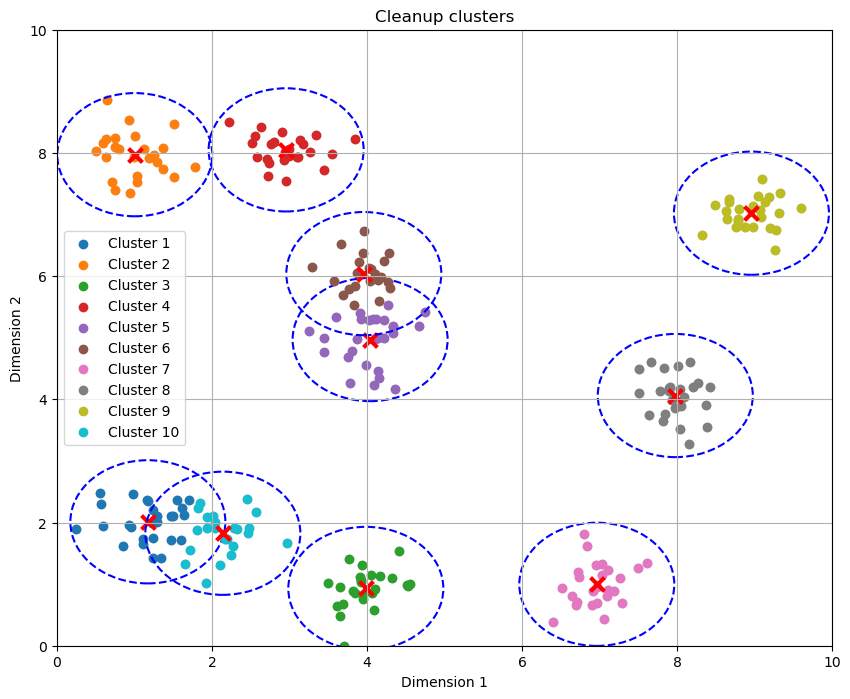

In [87]:
crawler = dCrawler(threshold=1.0)
crawler.fit(data) 
animate_clustering(crawler.history, data, crawler.threshold) #it will always show the final state of the clustering but the gif will show the process

In [50]:
print(range(len(crawler.history)))


range(0, 486)


In [60]:
print(crawler.history)

[(None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, None, 'Initial Crawl'), (None, 